In [3]:
import os
import pandas as pd
import numpy as np
import math

import tensorflow as tf
import keras_tuner as kt

# from tensorflow.python.keras.models import Sequential
# from tensorflow.python.keras.layers import Activation, Dense, Flatten
# import tensorflow.python.keras.optimizers
# import tensorflow.python.keras.metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
import tensorflow.keras.optimizers
import tensorflow.keras.metrics

#%%capture
data_file_path = os.path.join(os.getcwd(), "Data\\returnsData.csv")
returnsData = pd.read_csv(data_file_path)
#returnsData.info(verbose=True)
longReturns = returnsData[["YearQuarter", "gvkey", "quarterlyReturns"]] #"quarterlyVolatility",
#longReturns.info(verbose=True)
wideReturns = pd.pivot(longReturns, index="YearQuarter", columns="gvkey", values="quarterlyReturns")
#wideReturns.info(verbose=True)
#print(wideReturns.iloc[0:10,0:10])


class PreprocessData:

  def __init__(self, sample_length=2):

    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=wideReturns, targets=None,
        sequence_length=sample_length, sequence_stride=1, sampling_rate=1,
        batch_size=128,  shuffle=False, 
        start_index=None, end_index=None)

    for batch in dataset:
      data = batch
      print(data.shape)
      break

    trainSize = math.floor(data.shape[0] * 0.5)
    validationSize = math.floor(data.shape[0] * 0.75)
    testSize = data.shape[0]

    train = data[:trainSize, :, :]
    validation = data[trainSize:validationSize, :, :]
    test = data[validationSize:, :, :]

    def reshapeData(rawData):
      #[lags of YearQuarter, YearQuarter, gvkey] => [Batch, YearQuarter, None]
      reshapedData = np.transpose(a=rawData, axes=(2, 0, 1))
      reshapedData = np.reshape(reshapedData, (-1, rawData.shape[1]))
      reshapedData = reshapedData[~np.isnan(reshapedData).any(axis=1),:]
      reshapedData = np.expand_dims(reshapedData, axis=2)
      #np.asarray(reshapedData).astype('float32')
      return reshapedData

    train = reshapeData(train)
    validation = reshapeData(validation)
    test = reshapeData(test)

    xTrain, yTrain = train[:, :-1, :], train[:, -1, :]
    xVal, yVal = validation[:, :-1, :], validation[:, -1, :]
    xTest, yTest = test[:, :-1, :], test[:, -1, :]

    # train = tf.keras.preprocessing.timeseries_dataset_from_array(
    #     data=xTrainReshaped, targets=yTrainReshaped,
    #     sequence_length=sample_length, sequence_stride=1, sampling_rate=1,
    #     batch_size=batch_size,  shuffle=False)
    # validation = tf.keras.preprocessing.timeseries_dataset_from_array(
    #     data=xValReshaped, targets=yValReshaped,
    #     sequence_length=sample_length, sequence_stride=1, sampling_rate=1,
    #     batch_size=batch_size,  shuffle=False)
    # test = tf.keras.preprocessing.timeseries_dataset_from_array(
    #     data=xTestReshaped, targets=yTestReshaped,
    #     sequence_length=sample_length, sequence_stride=1, sampling_rate=1,
    #     batch_size=batch_size,  shuffle=False)


    normlayer = tf.keras.layers.Normalization(axis=None)
    normlayer.adapt(xTrain[:, 0, :]) #Calculates some returns multiple times
    self.xTrain, self.yTrain, self.xVal, self.yVal, self.xTest, self.yTest, self.normlayer = xTrain, yTrain, xVal, yVal, xTest, yTest, normlayer
    #return xTrain, yTrain, xVal, yVal, xTest, yTest, normlayer

#normlayer.adapt(xTrain[:,0,:])
#normlayer.adapt(xTrain[:,[0, -1],:])
# normlayer.adapt(wideReturns[trainSize, :])


In [4]:
# model = Sequential()
# model.add(normlayer)
# model.add(tf.keras.layers.LSTM(units=5)) #, input_shape=(,sample_length-1)   #mask
# model.add(Dense(units=1))

# model.compile(optimizer="adam", #tf.keras.optimizers.Adam(learning_rate=0.001)
#               loss="MeanAbsoluteError",
#               metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()])

# #model.fit(x=dataset, batch_size=8)#, validation_data=(xVal, yVal))
# model.fit(x=xTrain, y=yTrain, batch_size=32, validation_data=(xVal, yVal))

In [5]:
processedData = PreprocessData(24)
xTrain, yTrain = processedData.xTrain, processedData.yTrain
xVal, yVal= processedData.xVal, processedData.yVal
xTest, yTest = processedData.xTest, processedData.yTest
#normlayer = processedData.normlayer

normlayer = tf.keras.layers.Normalization(axis=None)
normlayer.adapt(xTrain)
xTrain = normlayer(xTrain)
xVal = normlayer(xVal)
xTest = normlayer(xTest)
#xTest = np.asarray(xTest).astype('float32')

#yTrain = normlayer(yTrain)
#yVal = normlayer(yVal)
#yTest = normlayer(yTest)


(30, 24, 9668)


In [6]:
2**np.linspace(start=0, stop=5, num=6)
#np.geomspace(start=1, stop=100, num=10)
(2**np.arange(4, 10)).tolist()
(2**np.arange(10)).tolist()

(10**np.arange(5, -5)).tolist()

# for n in range(0,1):
#     print("hey")

[]

In [11]:

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        #model.add(normlayer)
        #model.add(tf.keras.layers.BatchNormalization())

        # if modelType == "LSTM":
        #     model.add(tf.keras.layers.LSTM(units=units))
        # elif modelType == "GRU":
        #     model.add(tf.keras.layers.GRU(units=units))
        # elif modelType == "SimpleRNN":
        #     model.add(tf.keras.layers.SimpleRNN(units=units))
        
        #RNN_layers = hp.Int("RNN_layers", min_value=0, max_value=3)
        #for n in range(0, RNN_layers):

        RNN_type = hp.Choice("Model_type", ["RNN", "LSTM", "GRU", "FeedForward"])
        LNormMin = 0.00001
        LNormMax = 10
        sampling = "log"

        if RNN_type == "LSTM":
            model.add(tf.keras.layers.LSTM(
                units=hp.Choice("units", (2**np.arange(7)).tolist()),
                # input_shape=(sample_length-1,),
                dropout=hp.Float("general_dropout", min_value=0, max_value=0.99),
                kernel_regularizer=tf.keras.regularizers.L1L2(l1=hp.Float("L1", min_value=LNormMin, max_value=LNormMax, sampling =sampling),
                                                            l2=hp.Float("L2", min_value=LNormMin, max_value=LNormMax, sampling =sampling)),
                recurrent_regularizer=None,
                return_sequences=False
            ))

        elif RNN_type == "GRU":
            model.add(tf.keras.layers.GRU(
                units=hp.Choice("units", (2**np.arange(7)).tolist()),
                dropout=hp.Float("general_dropout", min_value=0, max_value=0.99),
                kernel_regularizer=tf.keras.regularizers.L1L2(l1=hp.Float("L1", min_value=LNormMin, max_value=LNormMax, sampling =sampling),
                                                            l2=hp.Float("L2", min_value=LNormMin, max_value=LNormMax, sampling =sampling)),
                recurrent_regularizer=None,
                return_sequences=False
            ))

        elif RNN_type == "RNN":
            model.add(tf.keras.layers.SimpleRNN(
                units=hp.Choice("units", (2**np.arange(7)).tolist()),
                dropout=hp.Float("general_dropout", min_value=0, max_value=0.99),
                kernel_regularizer=tf.keras.regularizers.L1L2(l1=hp.Float("L1", min_value=LNormMin, max_value=LNormMax, sampling =sampling),
                                                            l2=hp.Float("L2", min_value=LNormMin, max_value=LNormMax, sampling =sampling)),
                recurrent_regularizer=None,
                return_sequences=False
            ))

        else:
            model.add(Dense(
                units=hp.Choice("units", (2**np.arange(7)).tolist()),
                kernel_regularizer=tf.keras.regularizers.L1L2(l1=hp.Float("L1", min_value=LNormMin, max_value=LNormMax, sampling =sampling),
                                                            l2=hp.Float("L2", min_value=LNormMin, max_value=LNormMax, sampling =sampling))
            ))
            model.add(tf.keras.layers.Dropout(rate=hp.Float("general_dropout", min_value=0, max_value=0.99)))


        #model.add(tf.keras.layers.Dropout(rate=hp.Float("general_dropout", min_value=0, max_value=0.99)))

        #model.add(tf.keras.layers.LayerNormalization())
        model.add(Dense(units=1))




        #https://stackoverflow.com/questions/48714407/rnn-regularization-which-component-to-regularize
        optimizerName = hp.Choice("optimizer", ["Adam", "RMSprop"])
        #learning_rate = hp.Float("learning_rate", min_value=0.00001, max_value=1, sampling ="log")
        learning_rate = 0.001
        if optimizerName == "Adam":
            #optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", [0.01, 0.001, 0.0001]))
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        else: 
            #optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp.Choice("learning_rate", [0.01, 0.001, 0.0001]))
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        
        model.compile(optimizer=optimizer,
                      loss="mse",
                      metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()])
        return model

    def fit(self, hp, model, *args, **kwargs):
        
        # lag_length = hp.Int("lags", min_value=2, max_value=15, step=1)
        # dataForFitting = PreprocessData(lag_length)
        # xTrain=dataForFitting.xTrain
        # yTrain=dataForFitting.yTrain
        # xVal=dataForFitting.xVal
        # yVal=dataForFitting.yVal
        # xTest=dataForFitting.xTest
        # yTest=dataForFitting.yTest        
        
        return model.fit(
            x=xTrain, y=yTrain,
            batch_size=hp.Choice("batch_size", (2**np.arange(4, 10)).tolist()), 
            #batch_size=hp.Choice("batch_size", [32, 64]),
            epochs = 300,
            validation_data=(xVal, yVal),
            steps_per_epoch=500,
            #steps_per_epoch=hp.Choice("batch_size", (2**np.arange(4, 10)).tolist())
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=1)]
        )



from datetime import datetime
now = datetime.now().strftime("%d-%m-%Y_%H%M")
seed=187
trials:int = 10
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective="val_mean_squared_error",
    max_trials=trials,
    overwrite=True,
    seed=seed,
    directory="Results//LSTM_KerasTuner_ResultsDir",
    project_name=f"tune_hypermodel_{now}"
)


#earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=1, verbose=1, restore_best_weights=True)
#tuner.search(callbacks=[earlystopping_callback])
tuner.search()

#bestModel = tuner.get_best_models(num_models=1)
bestHPs = tuner.get_best_hyperparameters(num_trials=trials)
bestHPs[0].values




Trial 10 Complete [00h 01m 20s]
val_mean_squared_error: 15045.10546875

Best val_mean_squared_error So Far: 14951.525390625
Total elapsed time: 00h 11m 08s
INFO:tensorflow:Oracle triggered exit


{'Model_type': 'GRU',
 'units': 32,
 'general_dropout': 0.6163006673756249,
 'L1': 0.5959176005066202,
 'L2': 5.1559156967928116e-05,
 'optimizer': 'Adam',
 'batch_size': 512}

In [24]:
tuner.results_summary(num_trials=1)


Results summary
Results in Results//LSTM_KerasTuner_ResultsDir\tune_hypermodel_13-01-2023_0252
Showing 1 best trials
Trial summary
Hyperparameters:
Model_type: GRU
units: 32
general_dropout: 0.6163006673756249
L1: 0.5959176005066202
L2: 5.1559156967928116e-05
optimizer: Adam
batch_size: 512
Score: 14951.525390625


In [17]:
bestHPs = tuner.get_best_hyperparameters(num_trials=trials)
print(bestHPs[0].values, bestHPs[1].values, bestHPs[2].values)

results = pd.DataFrame([n.values for n in bestHPs])
pd.DataFrame.to_csv(results, f"Results//RandomSearchTunerMSE_{seed}_{now}.csv", index=False)

{'Model_type': 'GRU', 'units': 32, 'general_dropout': 0.6163006673756249, 'L1': 0.5959176005066202, 'L2': 5.1559156967928116e-05, 'optimizer': 'Adam', 'batch_size': 512} {'Model_type': 'GRU', 'units': 1, 'general_dropout': 0.8501681005628712, 'L1': 5.780328062829789, 'L2': 0.0006341240632756304, 'optimizer': 'RMSprop', 'batch_size': 512} {'Model_type': 'GRU', 'units': 16, 'general_dropout': 0.9367266446652331, 'L1': 5.687479636673409e-05, 'L2': 3.651309552104482, 'optimizer': 'RMSprop', 'batch_size': 128}


In [21]:
bestModel = tuner.get_best_models(num_models=1)


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for Results//LSTM_KerasTuner_ResultsDir\tune_hypermodel_13-01-2023_0252\trial_07\checkpoint

In [23]:
model = tuner.hypermodel.build(bestHPs[0])
model.get_config()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="MeanSquaredError",
              metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()])


In [25]:
model.fit(
    x=xTrain, y=yTrain,
    batch_size=512,
    epochs=300,
    validation_data=(xVal, yVal),
    steps_per_epoch=512,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_mean_squared_error', patience=1)]
)


Epoch 1/300
512/512 [==============================] - 33s 56ms/step - loss: 579.1841 - mean_squared_error: 573.4799 - mean_absolute_error: 13.8829 - val_loss: 15052.4014 - val_mean_squared_error: 14953.8496 - val_mean_absolute_error: 17.3352
Epoch 2/300
512/512 [==============================] - 29s 56ms/step - loss: 576.3951 - mean_squared_error: 572.8087 - mean_absolute_error: 13.9207 - val_loss: 15049.3721 - val_mean_squared_error: 14952.6250 - val_mean_absolute_error: 17.3452
Epoch 3/300
512/512 [==============================] - 29s 56ms/step - loss: 572.3671 - mean_squared_error: 570.3757 - mean_absolute_error: 13.9086 - val_loss: 15047.2764 - val_mean_squared_error: 14951.8047 - val_mean_absolute_error: 17.3530
Epoch 4/300
512/512 [==============================] - 29s 56ms/step - loss: 573.6564 - mean_squared_error: 573.4993 - mean_absolute_error: 13.9380 - val_loss: 15046.4678 - val_mean_squared_error: 14951.8711 - val_mean_absolute_error: 17.3532


In [28]:
model.evaluate(x=xTest, y=yTest)

modelPreds = model.predict(x=xTest)

modelTestMAE = sum(abs(yTest - modelPreds))/len(yTest)
modelTestMSE = sum((yTest-modelPreds)**2)/len(yTest)

1784/1784 [==============================] - 12s 6ms/step


In [34]:
# modelValMAE = sum(abs(yVal - modelValPreds))/len(yVal)
# modelValMSE = sum((yVal-modelValPreds)**2)/len(yVal)

modelTestMAE = sum(abs(yTest - modelPreds))/len(yTest)
modelTestMSE = sum((yTest-modelPreds)**2)/len(yTest)
print(modelTestMAE, modelTestMSE)

[16.21960982] [1056.52757059]


In [36]:
zeroValMAE = sum(abs(yVal))/len(yVal)
zeroValMSE = sum(yVal**2)/len(yVal)

zeroTestMAE = sum(abs(yTest))/len(yTest)
zeroTestMSE = sum(yTest**2)/len(yTest)



#1 - modelValMAE/zeroTestMAE, 1 - modelValMSE/zeroTestMSE
1 - 14951.525390625/zeroValMSE, 1 - modelTestMAE/zeroTestMAE, 1 - modelTestMSE/zeroTestMSE

(array([0.00651741]), array([-0.00022424]), array([0.00431798]))

In [37]:
model.fit(
    x=xVal, y=yVal,
    batch_size=512,
    epochs=300,
    validation_split=0.5,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_mean_squared_error', patience=1)]
)

Epoch 1/300
46/46 [==============================] - 3s 70ms/step - loss: 28732.2285 - mean_squared_error: 28468.6738 - mean_absolute_error: 16.3503 - val_loss: 1358.7174 - val_mean_squared_error: 1365.6440 - val_mean_absolute_error: 18.1084
Epoch 2/300
46/46 [==============================] - 3s 65ms/step - loss: 28729.9512 - mean_squared_error: 28465.8457 - mean_absolute_error: 16.3795 - val_loss: 1354.9111 - val_mean_squared_error: 1361.7949 - val_mean_absolute_error: 18.1486
Epoch 3/300
46/46 [==============================] - 3s 72ms/step - loss: 28725.0664 - mean_squared_error: 28461.8828 - mean_absolute_error: 16.5115 - val_loss: 1347.0519 - val_mean_squared_error: 1353.7694 - val_mean_absolute_error: 18.3126
Epoch 4/300
46/46 [==============================] - 3s 66ms/step - loss: 28722.6523 - mean_squared_error: 28460.4434 - mean_absolute_error: 16.7203 - val_loss: 1344.4725 - val_mean_squared_error: 1351.1207 - val_mean_absolute_error: 18.4279
Epoch 5/300
46/46 [=============

In [39]:
model.evaluate(x=xTest, y=yTest)
modelPreds2 = model.predict(x=xTest)

modelTest2MAE = sum(abs(yTest - modelPreds2))/len(yTest)
modelTest2MSE = sum((yTest-modelPreds2)**2)/len(yTest)

1 - modelTest2MAE/zeroTestMAE, 1 - modelTest2MSE/zeroTestMSE

1784/1784 [==============================] - 9s 5ms/step


(array([-0.01963968]), array([0.02269248]))

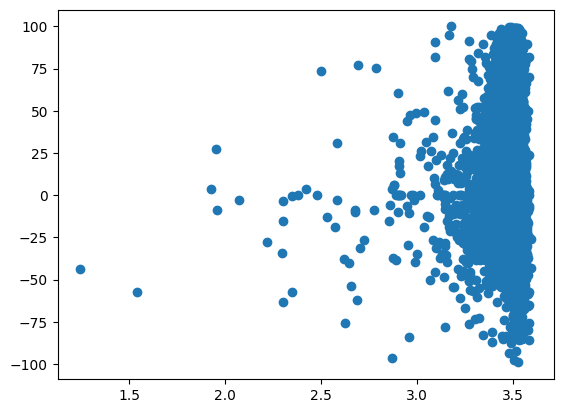

(PearsonRResult(statistic=0.02234574661981307, pvalue=9.368538505269972e-08),
 SpearmanrResult(correlation=0.05561992902724831, pvalue=2.4208289437682335e-40),
 SpearmanrResult(correlation=0.9999999999999998, pvalue=0.0),
 SpearmanrResult(correlation=0.004242069634406555, pvalue=0.3108978339936893))

In [67]:
import matplotlib.pyplot as plt
from matplotlib.scale import SymmetricalLogScale


#plt.scatter(modelPreds2, yTest)
#plt.scatter(modelPreds2[yTest<3000], yTest[yTest<3000])
plt.scatter(modelPreds2[yTest<100], yTest[yTest<100])
#plt.xscale("log")
#plt.yscale("log")
#plt.yscale(SymmetricalLogScale())
plt.show()

from scipy.stats import pearsonr, spearmanr, randint
pearsonr(modelPreds2.squeeze(), yTest.squeeze()), spearmanr(modelPreds2.squeeze(), yTest.squeeze()), spearmanr(yTest.squeeze(), yTest.squeeze()), spearmanr(randint.rvs(0, 1000, size=len(yTest)), randint.rvs(0, 1000, size=len(yTest)))

In [3]:
#This cell breaks the computer
# zeroForecastMAE = tf.keras.losses.MeanAbsoluteError().call(y_true=yVal,
#                                                    y_pred=np.zeros(len(yVal)))

# zeroForecastMSE = tf.keras.losses.MeanSquaredError().call(y_true=yVal,
#                                                   y_pred=np.zeros(len(yVal)))

#print(ZeroMAE, ZeroMSE)